# First we try and recreate the original Jurcsik and Kovacs paper equation

In [921]:
import blink_util

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import RocCurveDisplay

data = pd.read_csv("Jurcsik_Kovacs_1996_table1.csv")


# data filter

df = data.drop(columns=["star_name","shifted_data","A0", "N"])



df

,period,sigma,A1,phi1,A2,phi2,A3,phi3,A4,phi4,...,phi11,A12,phi12,A13,phi13,a14,phi14,A15,phi15,metallicity
0,0.442266,0.0091,0.3218,0.0179,0.1803,2.6140,0.1057,5.4850,0.0590,2.0787,...,5.5635,0.0044,1.9820,0.0058,4.6203,0.0051,0.7701,0.0044,3.6286,-0.06
1,0.722753,0.0155,0.3358,1.6476,0.1720,5.9663,0.1134,4.0763,0.0617,2.5336,...,1.7614,0.0006,1.7596,0.0013,0.5223,0.0011,5.6820,0.0012,4.6372,-1.69
2,0.616915,0.0141,0.2000,1.5871,0.0795,5.8195,0.0399,3.9177,0.0192,2.1835,...,3.6049,0.0008,1.2567,0.0009,5.3117,0.0007,3.8731,0.0008,1.9359,-0.92
3,0.574337,0.0184,0.3241,2.9349,0.1425,1.9110,0.1110,1.1494,0.0745,0.5286,...,4.1754,0.0048,3.5231,0.0061,3.0121,0.0056,2.3907,0.0050,1.7239,-1.39
4,0.459303,0.0180,0.4646,1.8951,0.2167,6.0193,0.1610,4.1492,0.0980,2.3481,...,2.3529,0.0080,0.6458,0.0050,5.6980,0.0048,2.3401,0.0009,0.6272,-1.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,0.557657,0.0135,0.3281,2.9453,0.1658,1.9827,0.1162,1.4013,0.0748,0.8343,...,4.8732,0.0038,4.3968,0.0046,3.8138,0.0050,3.2229,0.0051,2.6125,-1.15
80,0.475607,0.0139,0.3756,1.3720,0.2054,5.1373,0.1310,2.9590,0.0938,0.8321,...,3.3662,0.0046,0.6953,0.0034,4.6167,0.0018,2.0494,0.0011,5.7768,-0.60
81,0.525791,0.0377,0.4131,4.8677,0.1731,5.7203,0.1417,0.3700,0.1022,1.5990,...,2.7926,0.0102,3.8922,0.0096,5.0910,0.0088,0.0597,0.0077,1.3509,-1.54
82,0.656908,0.0184,0.2718,0.7286,0.1335,4.0737,0.0822,1.4576,0.0426,5.1255,...,0.8733,0.0028,4.4377,0.0014,1.3375,0.0010,4.4196,0.0009,1.7312,-1.02


# We now evaluate the relationship between parameters
We'll begin by setting up a new DF with the appropriate parameters

## $R_{mn}​=A_n/​A_m​​ $
We want the ratios between alphas so that our results are distance independent

In [922]:
jk_df = pd.DataFrame() # This is the dataframe we'll use to replicate Jurcsik and Kovac's results with Phi31
jk_df["period"] = df["period"]


def append_amp_ratios(original_df, new_df,filter=None):
    # Get amp ratios ex. A1/A2, A1/A3 etc.
    alpha_filter = (original_df.filter(filter) if filter else original_df.filter(regex="A", axis=1))
    for alpha in alpha_filter.columns:

        # alpha denom is an element of a list where alpha is not a part of, ex: for A1 alpha denom will be A2,A3 only for A[1-3]
        for alpha_denom in alpha_filter.drop(columns=[alpha]).columns:
            ratio_name = f"R_{alpha[1:]}{alpha_denom[1:]}"

            # append ratios
            new_df[ratio_name] = alpha_filter[alpha].to_numpy() / alpha_filter[alpha_denom].to_numpy()

append_amp_ratios(df, jk_df, filter=["A1","A2","A3"])

jk_df

,period,R_12,R_13,R_21,R_23,R_31,R_32
0,0.442266,1.784803,3.044465,0.560286,1.705771,0.328465,0.586245
1,0.722753,1.952326,2.961199,0.512210,1.516755,0.337701,0.659302
2,0.616915,2.515723,5.012531,0.397500,1.992481,0.199500,0.501887
3,0.574337,2.274386,2.919820,0.439679,1.283784,0.342487,0.778947
4,0.459303,2.143978,2.885714,0.466423,1.345963,0.346535,0.742963
...,...,...,...,...,...,...,...
79,0.557657,1.978890,2.823580,0.505334,1.426850,0.354160,0.700844
80,0.475607,1.828627,2.867176,0.546858,1.567939,0.348775,0.637780
81,0.525791,2.386482,2.915314,0.419027,1.221595,0.343016,0.818602
82,0.656908,2.035955,3.306569,0.491170,1.624088,0.302428,0.615730


## Computing $\phi_{nm}$
We get the values for phase difference parameters and measure their weights

In [923]:
def append_phi_diff(original_df, new_df,filter=None):
    

    phi_filter = (original_df.filter(filter) if filter else original_df.filter(regex='phi'))

    for phi_n1 in phi_filter.columns:

        for phi_n2 in phi_filter.drop(columns=[phi_n1]).columns:
            phi_name = f"phi{phi_n2[3:]}{phi_n1[3:]}"

            phi_n1_row = phi_filter[phi_n1].to_numpy()
            phi_n2_row = phi_filter[phi_n2].to_numpy()
            

            coef = int(phi_n2[3:])

            # append phase differences
            new_df[phi_name] = blink_util.twopi_normalize(phi_n1_row, phi_n2_row, coef=coef)


append_phi_diff(df, jk_df, filter=["phi1","phi2","phi3"])

jk_df["metallicity"] = df["metallicity"]

jk_df

,period,R_12,R_13,R_21,R_23,R_31,R_32,phi21,phi31,phi12,phi32,phi13,phi23,metallicity
0,0.442266,1.784803,3.044465,0.560286,1.705771,0.328465,0.586245,2.578200,5.431300,3.687085,3.926185,0.816085,4.210371,-0.06
1,0.722753,1.952326,2.961199,0.512210,1.516755,0.337701,0.659302,2.671100,5.416685,1.964485,5.026956,3.854485,4.096885,-1.69
2,0.616915,2.515723,5.012531,0.397500,1.992481,0.199500,0.501887,2.645300,5.439585,2.050785,5.308756,3.952585,4.267285,-0.92
3,0.574337,2.274386,2.919820,0.439679,1.283784,0.342487,0.778947,2.324385,4.911071,1.023900,1.699585,1.785500,5.895385,-1.39
4,0.459303,2.143978,2.885714,0.466423,1.345963,0.346535,0.742963,2.229100,4.747085,2.158985,4.940856,4.029085,4.004085,-1.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,0.557657,1.978890,2.823580,0.505334,1.426850,0.354160,0.700844,2.375285,5.131771,0.962600,1.736385,1.544000,5.463285,-1.15
80,0.475607,1.828627,2.867176,0.546858,1.567939,0.348775,0.637780,2.393300,5.126185,2.517885,0.113471,4.696185,5.502485,-0.60
81,0.525791,2.386482,2.915314,0.419027,1.221595,0.343016,0.818602,2.268085,4.616456,5.430585,2.058656,4.497700,4.980300,-1.54
82,0.656908,2.035955,3.306569,0.491170,1.624088,0.302428,0.615730,2.616500,5.554985,2.938085,1.802871,5.554185,1.158500,-1.02


# Finish up setting up the dataframe to recreate Jurcsik and Jovacs' equation

In [924]:
X = jk_df[["period", "phi31"]]
y = jk_df["metallicity"] 

model = LinearRegression()

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

model.fit(x_train, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


# Display weight of each parameter

In [925]:
coefficients = model.coef_
intercept = model.intercept_


coef_df = pd.DataFrame({'Params': list(X), 'Coefficients':coefficients})
coef_df

#Creating a table of what predicted weights are being attahced to each independent variable.

,Params,Coefficients
0,period,-5.157079
1,phi31,1.285370


We can see that the coefficients match up close to the ones in the equation from Jurcsik and Kovac's paper `[Fe/H] = -5.038-5.394*P+1.345*phi31`

# Graph model predictions

Mean Absolute Error (MEA): 0.11498217360494599
Mean Squared Error (MRE): 0.0316696444502092
R^2 Score: 0.884278658347794


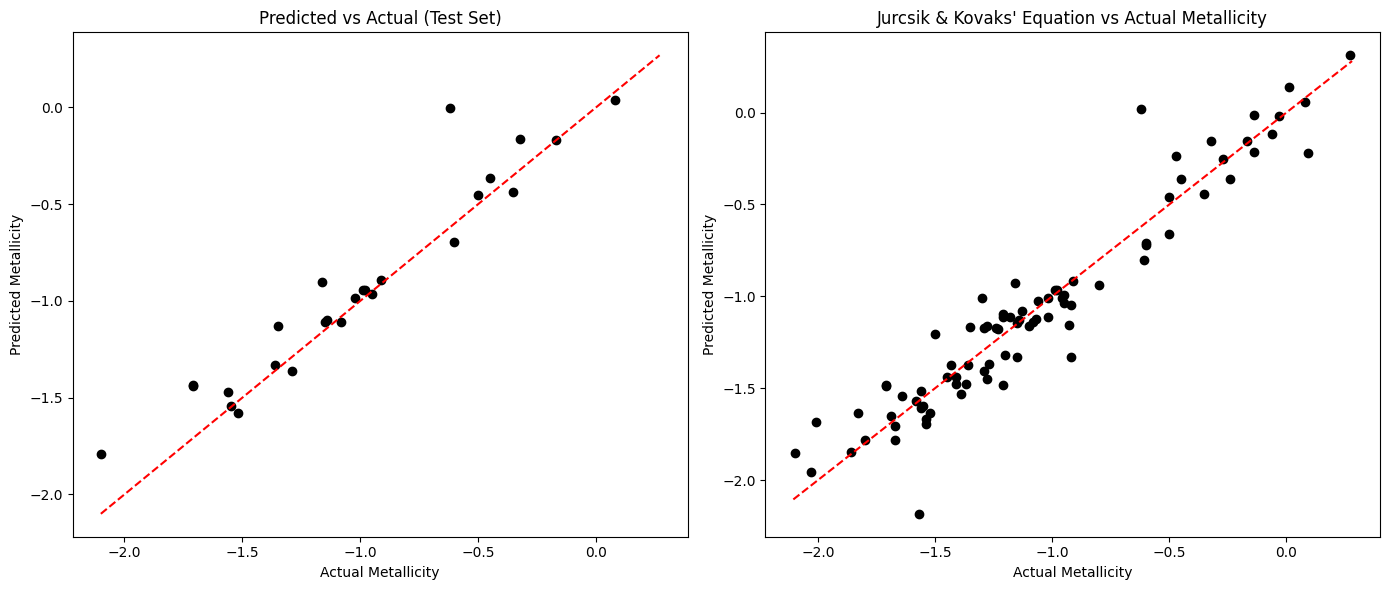

In [926]:
y_predict_test = model.predict(x_test)
y_predict_all = model.predict(X)

print(f"Mean Absolute Error (MEA): {mean_absolute_error(y_test, y_predict_test)}")

print(f"Mean Squared Error (MRE): {mean_squared_error(y_test, y_predict_test)}")

print(f"R^2 Score: {model.score(x_test, y_test)}")



fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(y_test, y_predict_test, color="black")
lims_test = [
    min(y_test.min(), y_predict_test.min()), max(y.max(), y_predict_test.max())
    ]
axes[0].plot(lims_test, lims_test, 'r--')
axes[0].set_xlabel("Actual Metallicity")
axes[0].set_ylabel("Predicted Metallicity")
axes[0].set_title("Predicted vs Actual (Test Set)")


Fe_on_H = blink_util.get_FoH(df, verbose=False)


axes[1].scatter(y, Fe_on_H, color="black")
lims_all = [min(y.min(), y_predict_all.min()), max(y.max(), y_predict_all.max())]
axes[1].plot(lims_all, lims_all, 'r--')
axes[1].set_xlabel("Actual Metallicity")
axes[1].set_ylabel("Predicted Metallicity")
axes[1].set_title("Jurcsik & Kovaks' Equation vs Actual Metallicity")

plt.tight_layout()
plt.show()

#Setting up Predicted vs. Actual for test data and the full set.

# Cross Validation
Here we use KFold and CV to measure the accuracy of the model

First we get the score for our first estimator

In [927]:
final_model = LinearRegression()

final_model.fit(X, y)



,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


Now we train our model using KFold splits with shuffled items and measure the scores

In [928]:

def get_metrics(estimator):
    kfold = KFold(n_splits=5, shuffle=True)

    scores = cross_val_score(estimator, X, y, cv=kfold, verbose=0)
    r2_scores = cross_val_score(estimator, X, y, cv=kfold, scoring='r2')
    mse_scores = -cross_val_score(estimator, X, y, cv=kfold, scoring='neg_mean_squared_error')

    print(f"CV Scores: {scores}")
    print("Cross-validated R^2 scores:", r2_scores)
    print("Average R^2:", np.mean(r2_scores))
    print("Cross-validated MSE:", mse_scores)
    print("Average MSE:", np.mean(mse_scores))

get_metrics(final_model)

CV Scores: [0.92117813 0.94059144 0.88027716 0.88947014 0.77219138]
Cross-validated R^2 scores: [0.71283399 0.96699463 0.65640205 0.93431012 0.88103192]
Average R^2: 0.8303145397398133
Cross-validated MSE: [0.02417175 0.05283199 0.0178586  0.01324532 0.04655028]
Average MSE: 0.030931586932827417


# Equations

In [929]:
#Attempt to get equation

m = model.coef_[0]      # slope
b = model.intercept_   # y-intercept

print(f"y = {m:.4f}x + {b:.4f}")

for i, coef in enumerate(model.coef_):
    print(f"b{i+1} = {coef}")

y = -5.1571x + -4.8315
b1 = -5.157078587728317
b2 = 1.2853702091156018


# Now we explore parameters which for $|$ coef $| > 0.18$

### We start by creating a new dataframe with all the parameters


In [930]:
test_df = pd.DataFrame()
test_df["period"] = df["period"]

append_amp_ratios(df, test_df)
append_phi_diff(df, test_df)

test_df["metallicity"] = df["metallicity"]
test_df

C:\Users\mewsi\AppData\Local\Temp\ipykernel_1076\185224340.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[ratio_name] = alpha_filter[alpha].to_numpy() / alpha_filter[alpha_denom].to_numpy()
C:\Users\mewsi\AppData\Local\Temp\ipykernel_1076\2024139058.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[phi_name] = blink_util.twopi_normalize(phi_n1_row, phi_n2_row, coef=coef)
C:\Users\mewsi\AppData\Local\Temp\ipykernel_1076\1545814513.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

,period,R_12,R_13,R_14,R_15,R_16,R_17,R_18,R_19,R_110,...,phi615,phi715,phi815,phi915,phi1015,phi1115,phi1215,phi1315,phi1415,metallicity
0,0.442266,1.784803,3.044465,5.454237,9.577381,15.852217,27.982609,54.542373,128.720000,123.769231,...,4.614941,3.935441,3.220427,3.290927,3.362612,3.348012,2.421097,1.430797,0.235182,-0.06
1,0.722753,1.952326,2.961199,5.442464,10.269113,19.869822,36.901099,52.468750,71.446809,111.933333,...,2.370341,1.772627,1.232312,0.905312,0.791297,1.017682,2.661868,3.070553,3.593053,-1.69
2,0.616915,2.515723,5.012531,10.416667,25.316456,45.454545,40.816327,44.444444,58.823529,95.238095,...,0.793485,3.899371,0.281771,2.803256,5.203056,1.159556,3.158641,5.277741,1.903241,-0.92
3,0.574337,2.274386,2.919820,4.350336,7.590164,13.504167,33.760417,45.647887,101.281250,83.102564,...,1.666485,5.505271,3.293571,1.375471,6.057056,4.062056,1.685856,5.734141,3.388841,-1.39
4,0.459303,2.143978,2.885714,4.740816,6.303935,8.883365,13.236467,23.464646,23.948454,27.820359,...,1.376600,5.211485,2.619285,0.064300,4.036685,1.736885,5.685771,3.827585,6.125671,-1.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,0.557657,1.978890,2.823580,4.386364,7.701878,13.902542,25.834646,51.265625,121.518519,218.733333,...,2.891971,5.933756,2.710656,5.964641,3.894241,1.268441,4.462727,1.267227,4.347012,-1.15
80,0.475607,1.828627,2.867176,4.004264,6.601054,11.079646,19.065990,26.083333,43.674419,75.120000,...,5.669112,3.911797,2.122097,0.173582,4.460568,2.653253,0.488738,4.916524,2.855609,-0.60
81,0.525791,2.386482,2.915314,4.042074,5.834746,8.642259,13.198083,20.250000,29.719424,36.883929,...,2.232985,2.046385,1.767571,1.353571,0.884771,0.499071,0.247771,0.095671,6.279841,-1.54
82,0.656908,2.035955,3.306569,6.380282,14.010309,30.886364,48.535714,39.391304,34.846154,38.828571,...,2.190971,4.686071,0.845471,2.972871,5.005756,0.679656,2.512856,3.964641,5.315541,-1.02


### We then create a new mode through an sk pipeline to get normalized coefficients  
We individually measure coefficients independent of other parameters so we can avoid interference from multilinear relations

In [931]:

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
      

coef_df = pd.DataFrame(columns=["Parameters", "Coefficients"])

model = make_pipeline(StandardScaler(), LinearRegression())

for param in test_df.drop(columns=["metallicity"]):

    X = test_df.filter([param])

    model.fit(X, y)
    normalized_coefficients = model.named_steps['linearregression'].coef_
    
    dat = {"Parameters": f"{param}", "Coefficients": normalized_coefficients[0]}

    coef_df.loc[len(coef_df)] = dat



# TODO: figure out better selection, maybe we can use p values?
# TODO: Need to stop growing dataframes as it is very innefficient, but for testing we'll stick with it

coef_df



,Parameters,Coefficients
0,period,-0.422627
1,R_12,-0.228378
2,R_13,-0.002586
3,R_14,-0.029954
4,R_15,-0.037143
...,...,...
379,phi1015,-0.016345
380,phi1115,0.017144
381,phi1215,0.035691
382,phi1315,0.004064


### Now we filter out parameters with weakest coefficients

In [932]:
param_filter = []
def filter_params(coefficients: pd.DataFrame, filter_list: list, threshold: float):
    for i, row in coefficients.iterrows():
        greater = abs(row["Coefficients"])> threshold
        if greater:
            param_filter.append(row["Parameters"])
            print(row["Parameters"],row["Coefficients"])
filter_params(coef_df,param_filter, .1)


period -0.42262719377997365
R_12 -0.22837835645795926
R_18 0.1415301682878611
R_21 0.26684386844455077
R_23 0.21095446604141513
R_28 0.1620286687580388
R_32 -0.2299150662551088
R_38 0.15690345004177172
R_42 -0.15110383329235852
R_48 0.1611879080093818
R_52 -0.12035149257722583
R_58 0.16407515358677247
R_65 0.10450910032188468
R_68 0.1822263211769457
R_78 0.19855833725192543
R_87 -0.1575399641177704
R_811 -0.10803725860599982
R_97 -0.11577082039197868
R_911 -0.14637383536836598
R_108 0.12933569262397318
R_1011 -0.14207069091812163
R_118 0.16414505955945005
R_1110 0.1399886316813135
R_128 0.15670186064859992
R_1210 0.10458663148196348
R_1311 -0.10250491750320455
R_1312 -0.12223117080009542
R_158 0.12154894445814828
phi21 0.14112727007345938
phi31 0.18683402249604403
phi41 0.11795987138795225
phi131 0.12105786006120654
phi122 -0.16575550120648763
phi13 -0.14290760444412567
phi73 0.1059852167723771
phi54 0.1302316765097591
phi124 0.14479232339150852
phi65 -0.11879138236374098
phi16 -0.1464

### Then we filter out parameters with low statistical significance

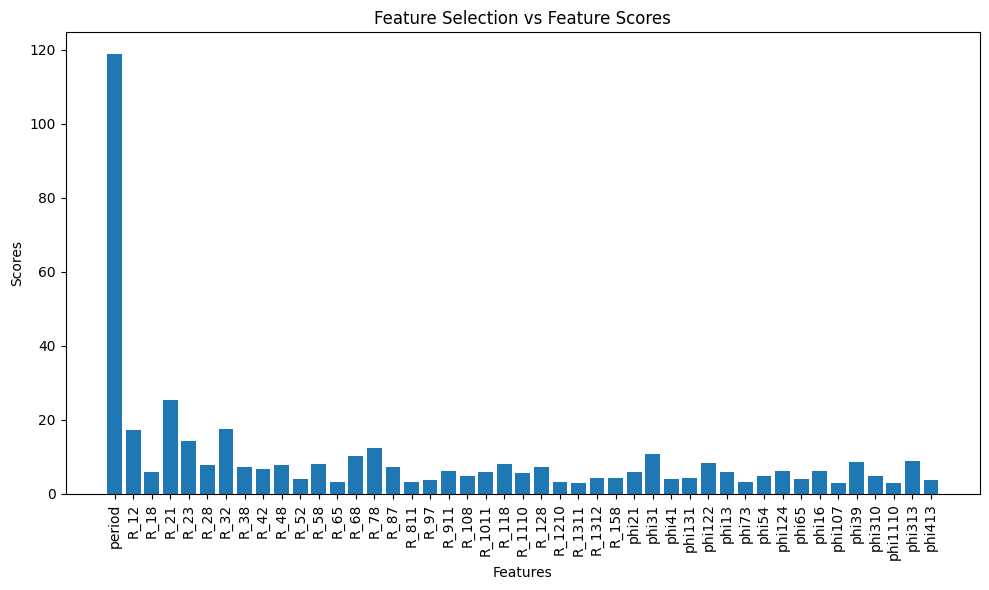

Selected Features:
Index(['period', 'R_12', 'R_21', 'R_23', 'R_32', 'R_68', 'R_78', 'phi31'], dtype='str')


In [933]:
from sklearn.feature_selection import SelectKBest, f_regression

X = test_df.filter(param_filter)
y = jk_df["metallicity"] 


# measures P values along with F values for stat significance
feature_selector = SelectKBest(score_func=f_regression, k=8)
X_new = feature_selector.fit_transform(X, y)


selected_indices = feature_selector.get_support(indices=True)
selected_features = X.columns[selected_indices]

scores = feature_selector.scores_

plt.figure(figsize=(10, 6))
plt.bar(range(len(X.columns)), scores)
plt.xticks(range(len(X.columns)), X.columns, rotation=90)
plt.xlabel('Features')
plt.ylabel('Scores')
plt.title('Feature Selection vs Feature Scores')
plt.tight_layout()
plt.show()

print("Selected Features:")
print(selected_features)



### Testing relationships to period
We know that for the equation used in the Jurcsik and Kovac paper on RR Lyrae is specifically a relation between period and Phi31 so we test period with other features

In [934]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Ridge

coef_df = pd.DataFrame(columns=["Parameters", "Coefficients"])

model = make_pipeline(StandardScaler(), LinearRegression())

for param in test_df.drop(columns=["metallicity"]):

    X = test_df.filter(["period",param])

    model.fit(X, y)
    normalized_coefficients = model.named_steps['linearregression'].coef_
    
    dat = {"Parameters": f"{param}", "Coefficients": normalized_coefficients[0]}

    coef_df.loc[len(coef_df)] = dat

coef_df

,Parameters,Coefficients
0,period,-0.422627
1,R_12,-0.389276
2,R_13,-0.440971
3,R_14,-0.437167
4,R_15,-0.440296
...,...,...
379,phi1015,-0.422472
380,phi1115,-0.424012
381,phi1215,-0.424464
382,phi1315,-0.423210


period -0.42262719377997365
R_13 -0.4409706350992437
R_14 -0.43716693706061327
R_15 -0.44029592173899657
R_16 -0.4346641943815828
R_17 -0.4563547914606521
R_111 -0.45753953467056707
R_112 -0.4578714922330811
R_113 -0.4400636914661356
R_115 -0.4245488219209032
R_24 -0.4445576883662294
R_25 -0.4515166239171105
R_26 -0.44266469772469363
R_27 -0.4652932841412737
R_211 -0.43509736884301803
R_212 -0.4260580089776292
R_215 -0.4253449238963248
R_31 -0.44931713101591786
R_34 -0.44418045616604157
R_35 -0.4586218568604766
R_36 -0.4468606511176277
R_37 -0.4670820119171917
R_311 -0.4308640762198253
R_312 -0.42611001941314225
R_315 -0.426726454356784
R_41 -0.45867204153890273
R_42 -0.4480189890547312
R_43 -0.4510860161249903
R_45 -0.4819652118727755
R_46 -0.46249854822519654
R_47 -0.4589915721423999
R_411 -0.4269297702276853
R_412 -0.424780633777052
R_415 -0.4293367280650414
R_51 -0.4924981505532842
R_52 -0.47839374264581946
R_53 -0.49219743451472964
R_54 -0.4981214461919406
R_56 -0.456794875509628


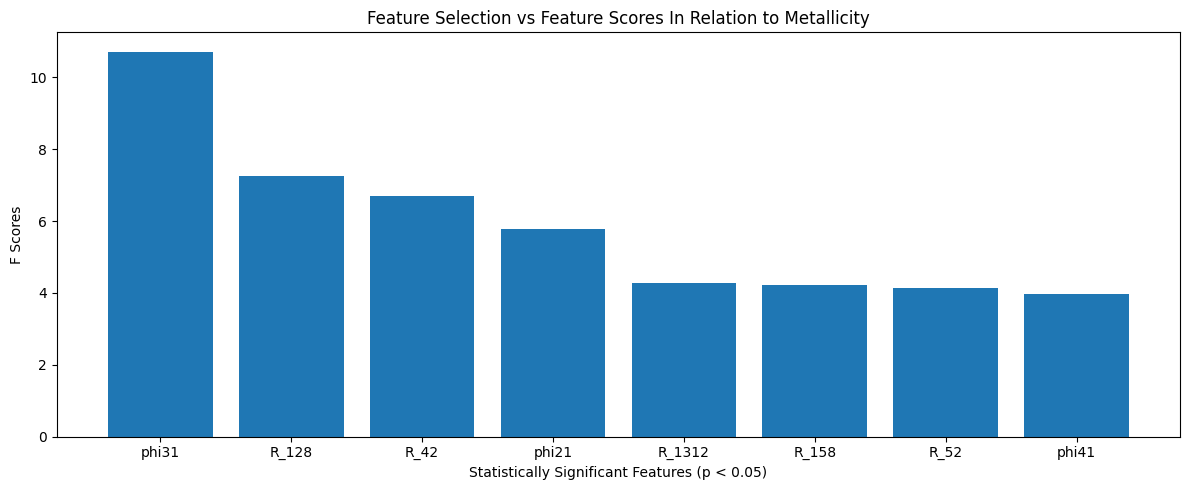

Statistically Significant Features:
    Feature    F Score   p-value
115   phi31  10.718329  0.001555
88    R_128   7.258511  0.008557
25     R_42   6.707503  0.011359
114   phi21   5.790542  0.018361
101  R_1312   4.268402  0.041984
109   R_158   4.218442  0.043173
34     R_52   4.131568  0.045326
116   phi41   3.961141  0.049894


In [935]:
param_filter = []

filter_params(coef_df, param_filter, .4226) # use period coeff as threshold

X = test_df.filter(param_filter).drop(columns=["period"])


# Use all features first
feature_selector = SelectKBest(score_func=f_regression, k="all")
feature_selector.fit(X, y)

scores = feature_selector.scores_
p_values = feature_selector.pvalues_

results = pd.DataFrame({
    "Feature": X.columns,
    "F Score": scores,
    "p-value": p_values
})

# p value threshold
alpha = 0.05
significant_features = results[results["p-value"] < alpha]

significant_features = significant_features.sort_values(
    by="F Score", ascending=False
)

plot_features = significant_features["Feature"].values
plot_scores = significant_features["F Score"].values

plt.figure(figsize=(12, 5))
plt.bar(range(len(plot_features)), plot_scores)
plt.xticks(range(len(plot_features)), plot_features)
plt.xlabel('Statistically Significant Features (p < 0.05)')
plt.ylabel('F Scores')
plt.title('Feature Selection vs Feature Scores In Relation to Metallicity')
plt.tight_layout()
plt.show()

print("Statistically Significant Features:")
print(significant_features)

# new filter from new params
significant_param_list = significant_features["Feature"].tolist()

In [ ]:

significant_param_list.append('period')
print(significant_param_list)

X = test_df.filter()


model.fit(X,y)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

model.fit(x_train, y_train)

y_predict_test = model.predict(x_test)
y_predict_all = model.predict(X)

print(f"Mean Absolute Error (MEA): {mean_absolute_error(y_test, y_predict_test)}")

print(f"Mean Squared Error (MRE): {mean_squared_error(y_test, y_predict_test)}")

print(f"R^2 Score: {model.score(x_test, y_test)}")



fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(y_test, y_predict_test, color="black")
lims_test = [
    min(y_test.min(), y_predict_test.min()), max(y.max(), y_predict_test.max())
    ]
axes[0].plot(lims_test, lims_test, 'r--')
axes[0].set_xlabel("Actual Metallicity")
axes[0].set_ylabel("Predicted Metallicity")
axes[0].set_title("Predicted vs Actual (Test Set)")


Fe_on_H = blink_util.get_FoH(df, verbose=False)


axes[1].scatter(y, Fe_on_H, color="black")
lims_all = [min(y.min(), y_predict_all.min()), max(y.max(), y_predict_all.max())]
axes[1].plot(lims_all, lims_all, 'r--')
axes[1].set_xlabel("Actual Metallicity")
axes[1].set_ylabel("Predicted Metallicity")
axes[1].set_title("Jurcsik & Kovaks' Equation vs Actual Metallicity")

plt.tight_layout()
plt.show()

TypeError: Must pass either `items`, `like`, or `regex`

### Now we test the model trained on our new filter

In [ ]:
model.fit(X_new,y)

get_metrics(model)

CV Scores: [ 0.23284662  0.44982359 -0.06574177 -0.00775004  0.10901648]
Cross-validated R^2 scores: [ 0.24063454 -0.22483037  0.05191411  0.06982301  0.67058435]
Average R^2: 0.16162512772056237
Cross-validated MSE: [0.32351036 0.11055805 0.18898326 0.38813211 0.23936528]
Average MSE: 0.25010981222046136
